## Imports

In [4]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [131]:
def read_data(filename):
    df = pd.read_parquet(filename)
    
    categories_columns = ['PUlocationID', 'DOlocationID']
    df[categories_columns] = df[categories_columns].astype('str')
    
    df['duration'] = df['dropOff_datetime'] -  df['pickup_datetime']
    
    df['duration'] = (df['duration'].dt.total_seconds() /60).astype('float64') # duration in minutes
    
    df.drop(columns=['SR_Flag', 'Affiliated_base_number'], inplace=True)
    
    # it's no really a NaN it's a string 'nan'
    df.loc[df['PUlocationID'] == 'nan', 'PUlocationID'] = -1
    df.loc[df['DOlocationID'] == 'nan', 'DOlocationID'] = -1
    
    return df.copy()

In [186]:
def select_data(data):
    
    categories_columns = ['PUlocationID', 'DOlocationID']
    
    dict_data = data[categories_columns].to_dict(orient='records')
    
    return dict_data

## Train Data

In [145]:
# train data
df_train = read_data('../datasets/fhv_tripdata_2021-01.parquet')

### Q1 - Read the data for January. How many records are there?

In [146]:
number_rows_df_train_original = df_train.shape[0]
print(f'Number of Rows: {number_rows_df_train_original}')

Number of Rows: 1154112


### Q2 - Computing duration

In [147]:
print(f'Mean time of duration: {df_train.duration.mean():.4f} minutes')

Mean time of duration: 19.1672 minutes


### Data preparation - How many records did you drop?

In [148]:
# filter time
df_train = df_train.loc[df_train['duration'].between(1,60)]

In [149]:
print(f'Number of Dropped Rows: {number_rows_df_train_original - df_train.shape[0]}')

Number of Dropped Rows: 44286


### Q3 - What's the fractions of missing values for the pickup location ID? 

In [170]:
print(f"Percentage of missing values Pickup Location ID: {len(df_train[df_train['PUlocationID'] == -1]) / len(df_train):.2%}")

Percentage of missing values Pickup Location ID: 83.53%


### Q4 - What's the dimensionality of this matrix?

In [174]:
y_train = df_train['duration']

dict_train = select_data(df_train)
dv = DictVectorizer()
x_train = dv.fit_transform(dict_train)

In [177]:
print(f'Number of columns: {x_train.shape[1]}')

Number of columns: 525


### Q5 - What's the RMSE on train?

#### LR MODEL

In [178]:
# define model
lr = LinearRegression()
# train model
lr.fit(x_train, y_train)

LinearRegression()

In [190]:
y_train_predict = lr.predict(x_train)
error_in_train = mean_squared_error(y_train, y_train_predict, squared=False)
print(f'RMSE in Train Data: {error_in_train:.4f}')

RMSE in Train Data: 10.5285


### Q6 - What's the RMSE on validation?

In [184]:
df_validation = read_data('../datasets/fhv_tripdata_2021-02.parquet')

# filter time
df_validation = df_validation.loc[df_validation['duration'].between(1,60)]

y_validation = df_validation['duration']

dict_validation = select_data(df_validation)

x_validation = dv.transform(dict_validation)

In [189]:
# predict on validation
y_predict = lr.predict(x_validation)

error_in_validation = mean_squared_error(y_predict, y_validation, squared=False)

print(f'RMSE in Validation Data: {error_in_validation:.4f}')

RMSE in Validation Data: 11.0143


### Extra - Plot

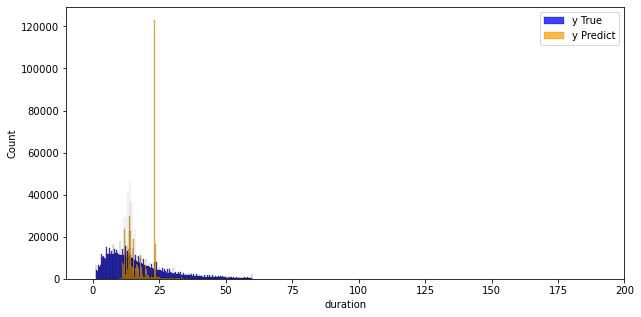

In [187]:
plt.figure(figsize=(10,5))
ax= sns.histplot(y_validation, label='y True', color='blue')
sns.histplot(y_predict, label='y Predict', color='orange', ax=ax)

ax.set_xlim(-10, 200)
plt.legend();